In [1]:
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.resnet50 import *
from tensorflow.keras.datasets import cifar100
# from keras.datasets import cifar10
# from keras.applications.resnet50 import *
# from keras.layers import *
# from keras.models import *
# import keras

import numpy as np
import pandas as pd
keras.__version__

'2.2.4-tf'

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [3]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
y_train

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [5]:
def get_model_bin_classify(feature_extractor):
    x = feature_extractor.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=feature_extractor.input, outputs=x)
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    return model

def get_train_samples(X_train, y_train, cls_li):
    mask = np.zeros(y_train.shape, dtype=np.bool)
    for cls in cls_li:
        mask += (y_train==cls)
    mask = np.squeeze(mask)
    return X_train[mask], y_train[mask]
    
def eva_bin_on_cls(model, X_valid, y_valid, cls_li, pos_samples):
    re = {}
    for cls in cls_li:
        mask = (y_valid==cls)
        mask = np.squeeze(mask)
        X_valid_cur_sess = X_valid[mask]
        y_valid_cur_sess = y_valid[mask]
        y_valid_cur_sess = convert_to_bin_samples(y_valid_cur_sess, pos_samples)
        loss, metric = model.evaluate(x=X_valid_cur_sess, y=y_valid_cur_sess, verbose=0)
        re[cls]= (loss, metric)
        # print('Evaluation on %s th class loss: %f. Acc: %f' % (cls, loss, metric))
    return re

def convert_to_bin_samples(labels, pos_samples):
    # arg1 = original labels, pos_samples = samples mark possitive
    re_label = np.zeros(labels.shape, dtype=np.bool)
    for it in pos_samples:
        re_label += (labels == it)
    return re_label

In [6]:
test_model = get_model_bin_classify(ResNet50(weights='imagenet', include_top=False))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# Continue exp on bin classifier with larger datasets
+ Method: Train a bin classifier incrementally with equal number of pos/neg samples every learning session
+ Purpose: observe whether the performance of previous seen classes will converge.

In [7]:
import matplotlib.pyplot as plt
import random

In [8]:
def print_eva_re_dic(dic):
    for cls, (loss, metric) in dic.items():
        print('Evaluation on %s th class loss: %f. Acc: %f' % (cls, loss, metric))

def train_schemer(train_set, eva_set, pos_sample=[0], scheme=None, label_pool=None):
    # scheme is a iterable obj consists with iterable objs reps label samples of each learning sessions
    (x_train, y_train), (x_test, y_test) = train_set, eva_set
    if scheme is None:
        pass
    else:
        for neg_sample in scheme:
            X_train_sess, y_train_sess = get_train_samples(x_train, y_train, pos_sample+neg_sample)
            y_train_sess = convert_to_bin_samples(y_train_sess, pos_sample)
            trained_model = yield X_train_sess, y_train_sess, neg_sample
        yield None    

In [9]:
def update_hist(hist, re_dict):
    n = 0
    for cls, acc_li in hist.items():
        n = len(acc_li)
        break
    for cls, (loss, acc) in re_dict.items():
        hist.setdefault(cls, [None for x in range(n)])
        hist[cls].append(acc)
    return hist

In [10]:
pos_sample = [0]
trainer = train_schemer((x_train, y_train), (x_test, y_test), scheme=[[x] for x in range(1, 100)])
acc_hist = {} # cls: [acc_on_session]
seen_labels = set(pos_sample)
while True:
    print("*"*40)
    print('Next session begins, ', end=' ')
    sess_inst = next(trainer)
    if sess_inst is None:
        break
    x_train_sess, y_train_sess, neg_sample = sess_inst
    print('newly arrived neg samples: ', neg_sample)
    test_model.fit(x=x_train_sess, y=y_train_sess, epochs=1, verbose=0)
    seen_labels = seen_labels.union(set(neg_sample))
    re_dict = eva_bin_on_cls(test_model, x_test, y_test, list(seen_labels), pos_sample)
    #print_eva_re_dic(re_dict)
    acc_hist = update_hist(acc_hist, re_dict)

****************************************
Next session begins,  newly arrived neg samples:  [1]


W0719 04:17:05.346508 139972823217984 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


****************************************
Next session begins,  newly arrived neg samples:  [2]
****************************************
Next session begins,  newly arrived neg samples:  [3]
****************************************
Next session begins,  newly arrived neg samples:  [4]
****************************************
Next session begins,  newly arrived neg samples:  [5]
****************************************
Next session begins,  newly arrived neg samples:  [6]
****************************************
Next session begins,  newly arrived neg samples:  [7]
****************************************
Next session begins,  newly arrived neg samples:  [8]
****************************************
Next session begins,  newly arrived neg samples:  [9]
****************************************
Next session begins,  newly arrived neg samples:  [10]
****************************************
Next session begins,  newly arrived neg samples:  [11]
****************************************
Next se

****************************************
Next session begins,  newly arrived neg samples:  [88]
****************************************
Next session begins,  newly arrived neg samples:  [89]
****************************************
Next session begins,  newly arrived neg samples:  [90]
****************************************
Next session begins,  newly arrived neg samples:  [91]
****************************************
Next session begins,  newly arrived neg samples:  [92]
****************************************
Next session begins,  newly arrived neg samples:  [93]
****************************************
Next session begins,  newly arrived neg samples:  [94]
****************************************
Next session begins,  newly arrived neg samples:  [95]
****************************************
Next session begins,  newly arrived neg samples:  [96]
****************************************
Next session begins,  newly arrived neg samples:  [97]
****************************************

In [11]:
test_model.evaluate(x=x_test, y=convert_to_bin_samples(y_test, [0]))

10000/10000 [==============================] - 8s 795us/sample - loss: 0.0358 - acc: 0.9900


[0.03576132787950337, 0.99]

In [12]:
import matplotlib.pylab as plt
def plot_acc(hist, cls=None):
    # cls = None means plot all cls
    # plt.ylim(0.3, 1.0)
    if cls is None:
        for cls, acc_li in hist.items():
            plt.plot(acc_li, label=str(cls))
    else:
        for v in cls:
            plt.plot(hist[v], label=str(v))
            

In [13]:
x_ = 0

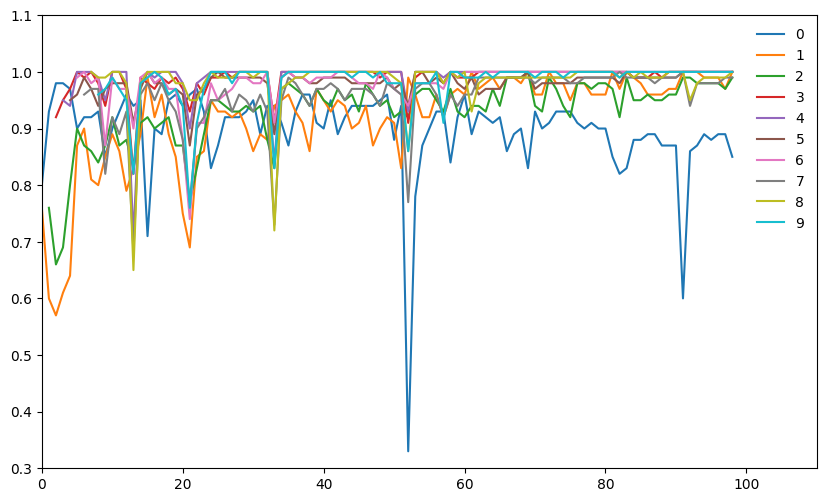

In [14]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

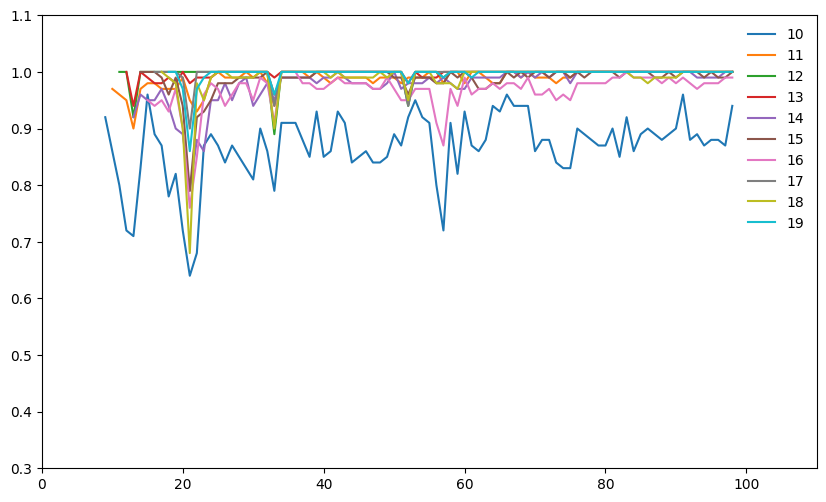

In [15]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

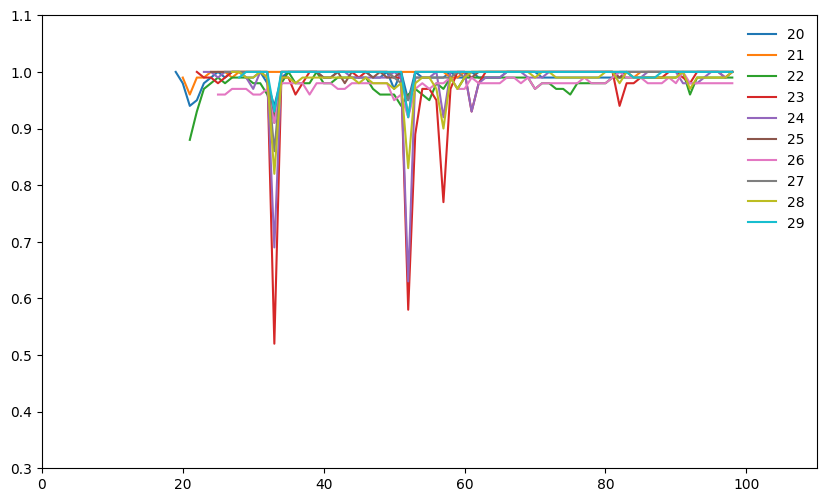

In [16]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

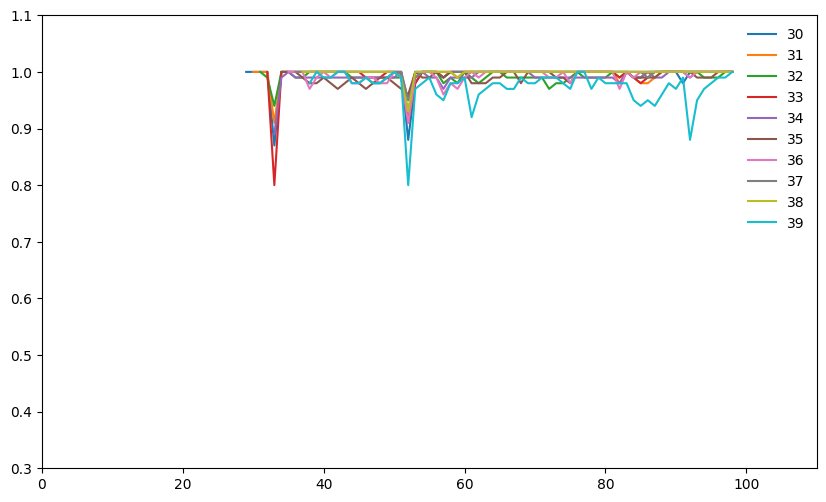

In [17]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

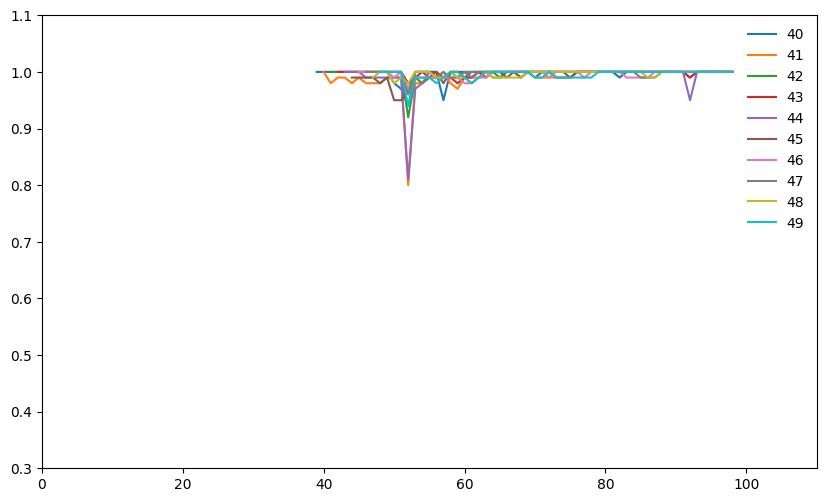

In [18]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

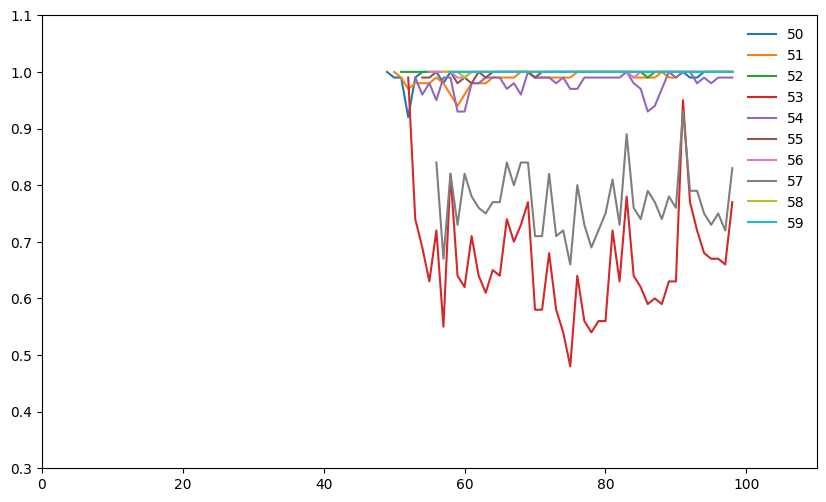

In [19]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

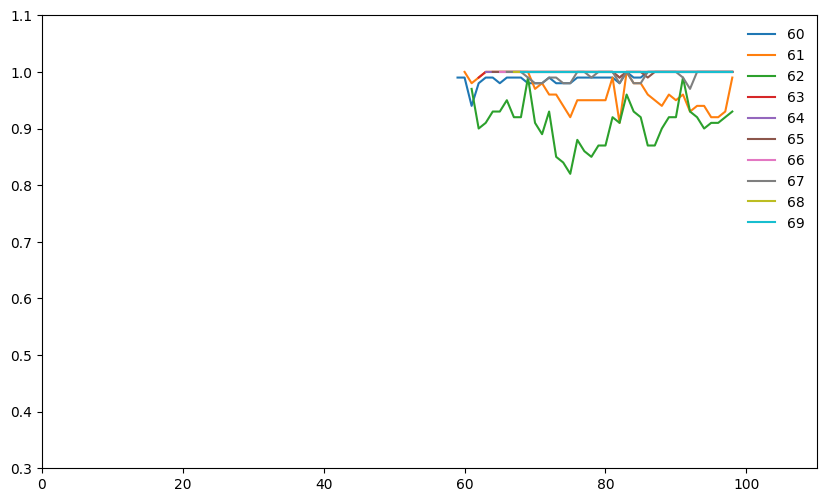

In [20]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

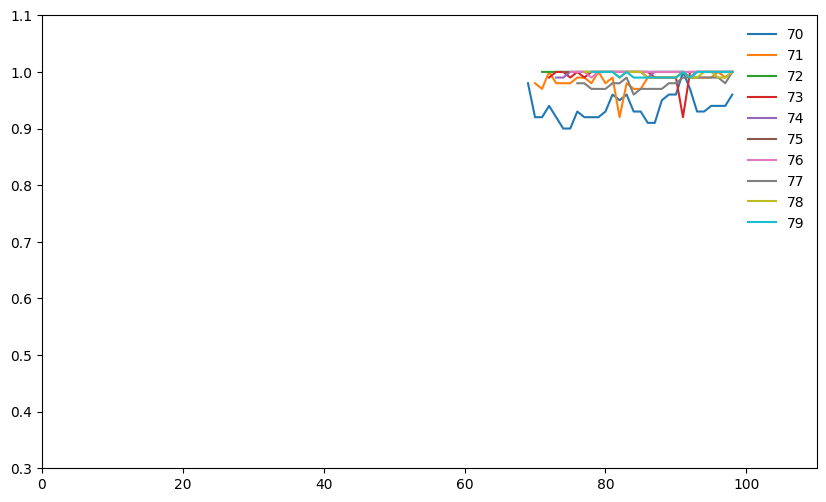

In [21]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

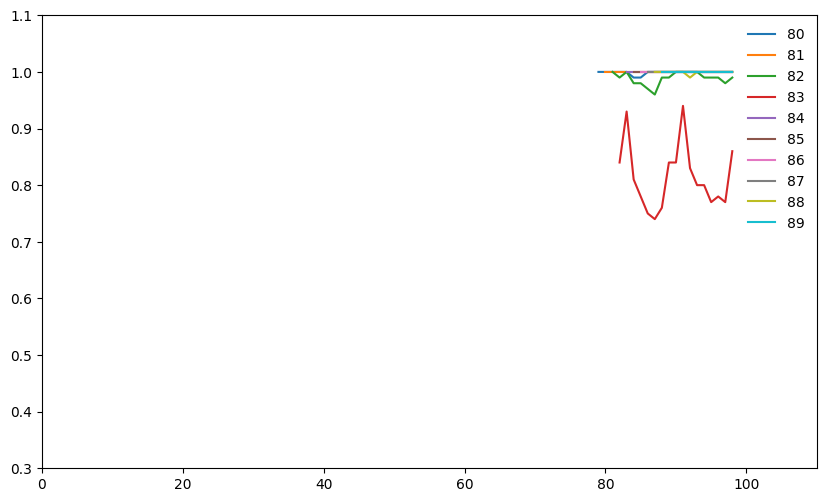

In [22]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10

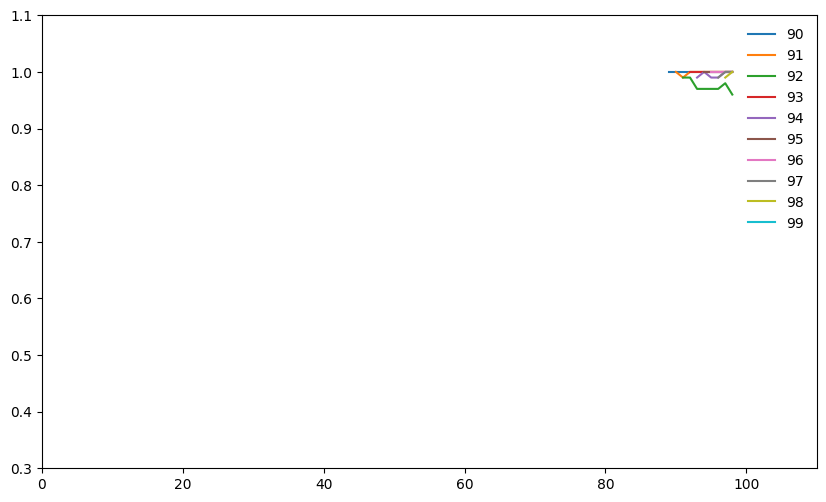

In [23]:
plt.figure(figsize=(10,6), dpi=100)
plt.xlim(0, 110)
plt.ylim(0.3, 1.1)
plot_acc(acc_hist, [x for x in range(x_, x_+10)])
plt.legend(loc='upper right', frameon=False)
x_ += 10